<a href="https://colab.research.google.com/github/sgoldyaev/DLS-GAN/blob/master/sgoldyaev_HW_NST_pix2pix_CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашка 
---------------------------------------

tldr:
    
* Выбрать архитектуру из рассказанных NST, pix2pix, CycleGAN$^1$
* Подберите к ней задачу, чтобы она вам нравилась
* Подберите еще одну задачу, которая уже решена (если не NST)
* Повторите решение, которое уже есть$^2$ (если не NST)
* Решите свою задачу

---------------------------------------
1. Расположены в порядке возрастания сложности и крутизны
2. Поверьте если вы сделаете этот пункт следующий будет в *разы* легче

## Если вы выбрали Neural Style Transfer
---------------------------------------
Тут все довольно просто на первый и на второй взгляд. Поэтому недосотаточно просто написать свою функцию потерь и сдать ноутбук. Если вы хотите приличных баллов, то у вас есть две опции:


1. Вы разделяете картинку на две части и переносите на них разные стили. <p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала к одной чати картинки, а потом к другой.</span></p> От вас ожидается, что вы отдадите нейросети два картинки стиля и она внутри себя(скорее внутри лосс функции) разделит выходную картинку на две части и к одной части применит один стиль, а к другой - второй. 

2. Вы переносите *одновременно* два стиля на одну картинку контента.
<p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала с одним стилем, а потом с другим.</span></p>
От вас ожидается, что вы модифицируете модель(скорее лосс модели) для того, чтобы два стиля учитывались с разными весами. 

## Если вы выбрали pix2pix
---------------------------------------------
Здесь от вас ожидается, что вы реализуете свою архитектуру для pix2pix модели. Пожалуйста не копируйте код из открытых репозиториев. Этот факт очень легко обнаружить. Перед тем, как приступить проверьте, что обе задачи, которые вы выбрали влезают на вашу видеокарту или на карту Google Colab. Если они не влезают, но вам все равно очень хочется, то вы можете израсходовать все безплатные триалы облаков(Google, Amazon, .. etc) во вселенной. 

## Если вы выбрали CycleGAN
--------------------------------------------
Здесь от вас ожидается, что вы реализуете свою архитектуру для CycleGAN модели. Пожалуйста не копируйте код из открытых репозиториев. Этот факт очень легко обнаружить. Перед тем, как приступить проверьте, что обе задачи, которые вы выбрали влезают на вашу видеокарту или на карту Google Colab. CycleGAN в этом смысле хуже, чем pix2pix, он ест больше памяти. Если они не влезают, но вам все равно очень хочется, то вы можете израсходовать все беcплатные триалы облаков(Google, Amazon, .. etc) во вселенной. 

## Remarks:
-----------------------------------------

* Это задание нужно для того, чтобы вы наступили на все грабли, что есть. Узнали об их существовании и научились обходить. Посмотрели на неработающие модели и поняли, что все тлен. Изгуглили весь интернет и в конце заставили это все работать. Поверьте, оно того стиот. Не откладывайте это задание на ночь перед сдачей, так как весь смысл \*пуф\* улетучится.

* У вас два союзника в этой борьбе:
    1. Оригинальная статья, те психи, что ее писала как то заставили свою модель работать. Их мысли, которыми они спроводили свое детище, позволят вам написать свой вариант алгоритма. 
    2. Гугл, он знает ответы на почти все ваши вопросы, но у него есть две ипостаси одна простая в обещении и вы все ее занаете(русскоязычная), а есть еще одна, которая кусается, но знает больше(англоязычная). Если не знаете языва - учите на ходу :)
    
* На самом деле у вас есть еще один союзник, это ментор проекта(или лектор или семинарист). Его ресурсом нужно пользоваться в ситуации, в которой вы не можете(занчит попытались и не вышло) найти ответов, используя Гугл и статью.

* Сдавать это все нужно следующим образом. Код вы кидаете на github и отправляете ссылку туда, куда вам сказали(в телеграм, степик или еще куда-то)

In [0]:
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from torchvision import datasets, transforms
from torchsummary import summary
from torch.autograd import Variable
from torch.utils.data import DataLoader
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 42

In [0]:
class BasicBlock(nn.Module):
  def __init__(self, in_features, out_features, kernel_size=3, stride=1, dilation=1):
    super(BasicBlock, self).__init__()

    self.convolution = nn.Sequential(
        nn.Conv2d(in_features, 64, kernel_size=1, stride=stride, dilation=dilation),
        nn.InstanceNorm2d(out_features),
        nn.ReLU(inplace=True),
        
        nn.Conv2d(64, 64, kernel_size=kernel_size, stride=stride, dilation=dilation, padding=1),
        nn.InstanceNorm2d(out_features),
        nn.ReLU(inplace=True),

        nn.Conv2d(64, out_features, kernel_size=1, stride=stride, dilation=dilation),
        nn.InstanceNorm2d(out_features),
      )
    
    self.shortcut = nn.Sequential(
        nn.Conv2d(in_features, out_features, kernel_size=kernel_size, stride=stride, dilation=dilation, padding=1),
        nn.InstanceNorm2d(out_features),
      )

    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    cnv = self.convolution(x)
    cut = self.shortcut(x)
    return (cnv+x)

class ResidualBlock(nn.Module):
  def __init__(self, in_features, out_features, kernel_size=3, stride=1, dilation=1, padding=1):
    super(ResidualBlock, self).__init__()

    self.convolution = nn.Sequential(
        nn.Conv2d(in_features, out_features, kernel_size=kernel_size, stride=stride, dilation=dilation, padding=padding),
        nn.InstanceNorm2d(out_features),
        nn.ReLU(inplace=True),

        nn.Conv2d(out_features, out_features, kernel_size=kernel_size, stride=stride, dilation=dilation, padding=padding),
        nn.InstanceNorm2d(out_features),
      )
    
    self.shortcut = nn.Sequential(
        nn.Conv2d(in_features, out_features, kernel_size=kernel_size*2-1, stride=stride, dilation=dilation, padding=padding*2),
        nn.InstanceNorm2d(out_features),
      )

    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    cnv = self.convolution(x)
    cut = self.shortcut(x)
    #return (cnv + x)
    return (cnv + cut)

class DownsamplingBlock(nn.Module):
  def __init__(self, in_features, out_features, kernel_size=3, stride=1, dilation=1, padding=0):
    super(DownsamplingBlock, self).__init__()

    self.convolution = nn.Sequential(
        nn.Conv2d(in_features, out_features, kernel_size=kernel_size, stride=stride, dilation=dilation, padding=padding),
        nn.InstanceNorm2d(out_features),
        nn.ReLU(inplace=True),
      )

  def forward(self, x):
    cnv = self.convolution(x)
    return (cnv)

class UpsamplingBlock(nn.Module):
  def __init__(self, in_features, out_features, kernel_size=3, stride=1, dilation=1, padding=0, output_padding=0):
    super(UpsamplingBlock, self).__init__()

    self.deconv = nn.ConvTranspose2d(in_features, out_features, kernel_size=kernel_size, stride=stride, dilation=dilation, padding=padding, output_padding=output_padding)
    self.output = nn.Sequential(
        nn.InstanceNorm2d(out_features),
        nn.ReLU(inplace=True),
      )

  def forward(self, x, output_size):
    cnv = self.deconv(x, output_size=output_size)
    cnv = self.output(cnv)
    return (cnv)

### U-model
class GeneratorU(nn.Module):
  def __init__(self, in_features):
    super(GeneratorU, self).__init__()

    self.enc1 = DownsamplingBlock(in_features, 16)
    self.enc2 = DownsamplingBlock(16, 32)
    self.enc3 = DownsamplingBlock(32, 64)
    
    self.bottleneck = nn.Sequential(
        BasicBlock(64, 64),
    )

    self.dec3 = UpsamplingBlock(64, 32)
    self.dec2 = UpsamplingBlock(32, 16)
    self.dec1 = UpsamplingBlock(16, in_features)

  def forward(self, x):
    e1 = self.enc1(x)
    e2 = self.enc2(e1)
    e3 = self.enc3(e2)
    b = self.bottleneck(e3)
    d3 = self.dec3(b, output_size=e2.size())
    d2 = self.dec2(d3, output_size=e1.size())
    d1 = self.dec1(d2, output_size=x.size())
    return d1

class DiscriminatorU(nn.Module):
  def __init__(self, in_features, out_features):
    super(DiscriminatorU, self).__init__()

    self.layers = nn.Sequential(
        ResidualBlock(in_features, 16, kernel_size=1, stride=1, padding=0),
        ResidualBlock(16, 32, kernel_size=1, stride=1, padding=0),
        ResidualBlock(32, 64, kernel_size=1, stride=1, padding=0),

        BasicBlock(64, 64),

        ResidualBlock(64, 32, kernel_size=1, stride=1, padding=0),
        ResidualBlock(32, 16, kernel_size=1, stride=1, padding=0),
        ResidualBlock(16, 8, kernel_size=1, stride=1, padding=0),
    )

    self.out = nn.Sequential(
        nn.Linear(8 * 1 * 28 * 28, 4),
        nn.Linear(4, out_features),
        nn.Sigmoid()        
    )

  def forward(self, x):
    x = self.layers(x)
    x = x.view(x.size(0), -1)

    return self.out(x)

### Linear model
class GeneratorL(nn.Module):
  def __init__(self, out_size):
    super(GeneratorL, self).__init__()

    self.out_size = out_size
    self.n_elements = np.array(out_size).prod()
    self.layers = nn.Sequential(
        nn.Linear(self.n_elements, 256),
        nn.ReLU(),

        nn.Linear(256, 512),
        nn.ReLU(),

        nn.Linear(512, 1024),
        nn.ReLU(),

        nn.Linear(1024, self.n_elements),
        nn.Tanh(),
    )

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    y = self.layers(x)
    #y = torch.tanh(y)
    y = y.view(-1, self.out_size[0], self.out_size[1], self.out_size[2])
    return y

class DiscriminatorL(nn.Module):
  def __init__(self, out_size, out_features):
    super(DiscriminatorL, self).__init__()

    self.out_size = out_size
    self.n_elements = np.array(out_size).prod()
    self.layers = nn.Sequential(
        nn.Linear(self.n_elements, 1024),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(256, self.n_elements-3),
        nn.ReLU(),
        nn.Dropout(0.3),
    )

    self.out = nn.Sequential(
        nn.Linear(self.n_elements-3, out_features),
        nn.Sigmoid()        
    )

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    y = self.layers(x)
    y = self.out(y)
    return y

class Generator(nn.Module):
  def __init__(self, in_features):
    super(Generator, self).__init__()

    self.enc1 = DownsamplingBlock(in_features, 16, stride=1, dilation=1)
    self.enc2 = DownsamplingBlock(16, 32, stride=1, dilation=1)
    self.enc3 = DownsamplingBlock(32, 64, stride=1, dilation=1)
    
    self.bottleneck = nn.Sequential(
        BasicBlock(64, 64),
    )

    self.dec3 = UpsamplingBlock(2*64, 32, stride=1, dilation=1)
    self.dec2 = UpsamplingBlock(2*32, 16, stride=1, dilation=1)
    self.dec1 = UpsamplingBlock(2*16, in_features, stride=1, dilation=1)

  def forward(self, x):
    e1 = self.enc1(x)
    e2 = self.enc2(e1)
    e3 = self.enc3(e2)

    b = self.bottleneck(e3)

    d3 = self.dec3(torch.cat([b, e3], dim=1), output_size=e2.size())
    d2 = self.dec2(torch.cat([d3, e2], dim=1), output_size=e1.size())
    d1 = self.dec1(torch.cat([d2, e1], dim=1), output_size=x.size())
    return d1


class Discriminator(nn.Module):
  def __init__(self, in_features, out_features):
    super(Discriminator, self).__init__()

    self.layers = nn.Sequential(
        nn.Conv2d(in_features, 16, kernel_size=3, stride=2, padding=1),
        nn.InstanceNorm2d(16),
        nn.ReLU(inplace=True),

        nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
        nn.InstanceNorm2d(32),
        nn.ReLU(inplace=True),

        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        nn.InstanceNorm2d(64),
        nn.ReLU(inplace=True),
    )

    self.out = nn.Sequential(
        nn.Linear(64 * 4 * 4, out_features),
        nn.Sigmoid()        
    )

  def forward(self, x):
    x = self.layers(x)
    x = x.view(x.size(0), -1)

    return self.out(x)

In [3]:
out_size = (1, 28, 28)
g = GeneratorL(out_size).to(device)
d = DiscriminatorL(out_size, 1).to(device)
summary(g, out_size), summary(d, out_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
              ReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 512]         131,584
              ReLU-4                  [-1, 512]               0
            Linear-5                 [-1, 1024]         525,312
              ReLU-6                 [-1, 1024]               0
            Linear-7                  [-1, 784]         803,600
              Tanh-8                  [-1, 784]               0
Total params: 1,661,456
Trainable params: 1,661,456
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 6.34
Estimated Total Size (MB): 6.38
----------------------------------------------------------------
--------------------------------------

(None, None)

In [4]:
traintransform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5,), std=(0.5,)),
     ])

imagedataset = torchvision.datasets.MNIST('mnist', train=True, transform=traintransform, download=True)
predsdataset = torchvision.datasets.MNIST('mnist', train=False, transform=traintransform, download=True)

(trainidx, validx), batch_size = train_test_split(range(len(imagedataset)), test_size=0.25, random_state=SEED, stratify=imagedataset.targets), 10*1024
#trainidx, validx, batch_size = (imagedataset.targets == 3).nonzero()[:100].squeeze(), (imagedataset.targets).nonzero()[:30].squeeze(), 1

trainsubset = torch.utils.data.Subset(imagedataset, trainidx)
valsubset = torch.utils.data.Subset(imagedataset, validx)
predsubset = torch.utils.data.Subset(imagedataset, range(0, 40))

trainloader = torch.utils.data.DataLoader(trainsubset, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
valloader = torch.utils.data.DataLoader(valsubset, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
predsloader = torch.utils.data.DataLoader(predsubset, batch_size=10, num_workers=8, pin_memory=True, shuffle=False)

print (len(imagedataset), len(trainsubset), len(valsubset), len(predsdataset), np.bincount(imagedataset.targets[trainsubset.indices]), np.bincount(imagedataset.targets[valsubset.indices]))

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...
Done!



60000 45000 15000 10000 [4442 5056 4469 4598 4381 4066 4439 4699 4388 4462] [1481 1686 1489 1533 1461 1355 1479 1566 1463 1487]


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


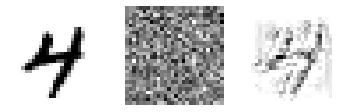

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
image = images[0]

m1 = GeneratorL((1, 28, 28))
m2 = Generator(1)

y1 = m1(images[:1].view(-1, 28*28))
y2 = m2(images[:1])

figure = plt.figure()
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(image.numpy().squeeze(), cmap='gray_r');

plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(y1[0].detach().numpy().squeeze(), cmap='gray_r');

plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(y2[0].detach().numpy().squeeze(), cmap='gray_r');

In [0]:
m = Discriminator(1, 1).to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(m.parameters())

train_losses, val_losses, train_acc, val_acc = [], [], [], []
for epoch in range(0, 20):
  epoch_train_losses, epoch_val_losses, epoch_train_acc, epoch_val_acc = [], [], [], []
  for i, (inputs, labels) in enumerate(trainloader):

    labels = torch.ones((labels.shape[0], 1))

    inputs = inputs.to(device)
    labels = labels.to(device)

    m.train()
    optimizer.zero_grad()

    y = m(inputs)
    loss = criterion(y, labels)
    pred = torch.argmax(y, dim=1)
    acc = f1_score(labels.to('cpu'), pred.to('cpu'), average='micro')    

    loss.backward()
    optimizer.step()

    epoch_train_losses.append(loss.item())
    epoch_train_acc.append(acc)

    m.eval()
    with torch.no_grad():
      for inputs, labels in valloader:
        labels = torch.ones((labels.shape[0], 1))

        inputs = inputs.to(device)
        labels = labels.to(device)

        y = m.forward(inputs)
        loss = criterion(y, labels)
        pred = torch.argmax(y, dim=1)
        acc = f1_score(labels.to('cpu'), pred.to('cpu'), average='micro')

        epoch_val_losses.append(loss.item())
        epoch_val_acc.append(acc)
 
  train_losses.append(np.mean(epoch_train_losses))
  val_losses.append(np.mean(epoch_val_losses))

  train_acc.append(np.mean(epoch_train_acc))
  val_acc.append(np.mean(epoch_val_acc))

  print ('epoch:{}. train loss:{:.4f}, acc:{:.2%}, val loss:{:.4f}, acc:{:.2%}'.format(epoch, train_losses[-1], train_acc[-1], val_losses[-1], val_acc[-1]))

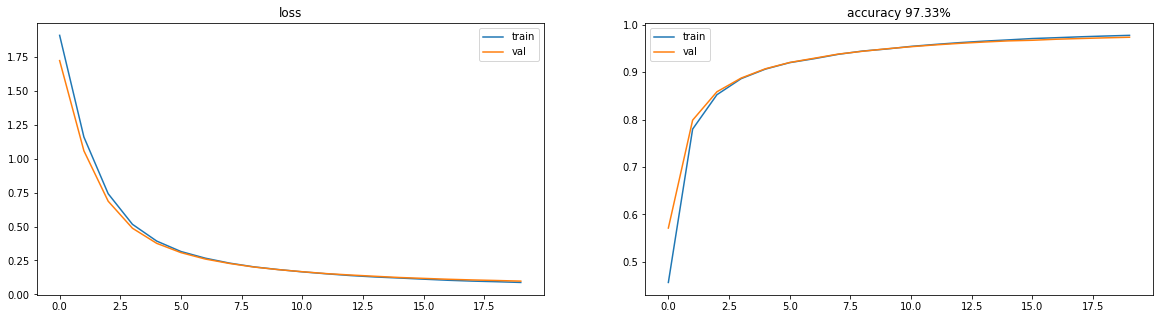

In [0]:
plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.title(label='loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.title(label='accuracy {:.2%}'.format(val_acc[-1]))
plt.legend()

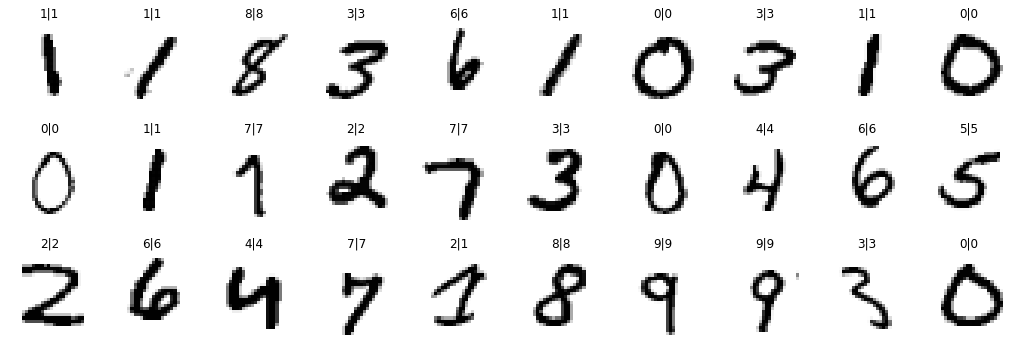

In [0]:
images_results = []
preds_results = []
label_results = []

m.eval()
with torch.no_grad():
  for i, (inputs, labels) in enumerate(predsloader):
    inputs = inputs.to(device)
    #print(labels)
    
    preds = m(inputs)
    
    inputs = inputs.to('cpu')
    preds = preds.to('cpu')

    for idx in range(len(inputs)):

      img = inputs[idx].squeeze()
      pred = torch.argmax(preds[idx]).numpy().squeeze()
      label = labels[idx].numpy().squeeze()
      
      images_results.append(img)
      preds_results.append(pred)
      label_results.append(label)

fig, ax = plt.subplots(nrows=int(len(images_results)/10), ncols=10, figsize=(18, 6), sharey=True, sharex=True)
for i, fig_x in enumerate(ax.flatten()):
  fig_x.axis('off')
  fig_x.imshow(images_results[i], cmap='gray_r')
  fig_x.set_title('{}|{}'.format(preds_results[i], label_results[i]))

GAN (MNIST)
---
![alt text](https://media.springernature.com/lw785/springer-static/image/chp%3A10.1007%2F978-3-319-78452-6_5/MediaObjects/456829_1_En_5_Fig1_HTML.gif)

In [0]:
ganidx, batch_size = (imagedataset.targets == 3).nonzero().squeeze(), 1024

gansubset = torch.utils.data.Subset(imagedataset, ganidx)
ganloader = torch.utils.data.DataLoader(gansubset, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

size = (1, 28, 28)
lr = 2e-4
discriminator = DiscriminatorL(size, 1).to(device)
generator = GeneratorL(size).to(device)

criterion_D = torch.nn.BCELoss()
criterion_G = torch.nn.BCELoss()

optimizer_D = torch.optim.AdamW(discriminator.parameters(), lr=lr, weight_decay=1e-3, amsgrad=True)
optimizer_G = torch.optim.AdamW(generator.parameters(), lr=lr, weight_decay=1e-3, amsgrad=True)
#optimizer_G = torch.optim.AdamW(itertools.chain(generator.parameters(), discriminator.parameters()), lr=lr)

losses_D = []
losses_G = []

outputs_G, outputs_D = [], []

for epoch in range(0, 200):
  epoch_losses_D, epoch_losses_G = [], []
  for inputs, labels in ganloader:

    ## Discrimator
    for step_D in range(10):
      discriminator.train()
      discriminator.zero_grad()

      real_input, real_output = inputs.to(device), torch.ones(labels.shape[0], 1).to(device) # labels.to(device)
      output_D = discriminator(real_input)
      loss_D_real = criterion_D(output_D, real_output)

      fake_input, fake_output = torch.randn(inputs.size()).to(device), torch.zeros(labels.shape[0], 1).to(device)
      fake_input, fake_output = Variable(fake_input), Variable(fake_output)
      output_D = discriminator(fake_input)
      loss_D_fake = criterion_D(output_D, fake_output)

      loss_D = (loss_D_real + loss_D_fake)
      #loss_D = (loss_D_real)

      loss_D.backward()
      optimizer_D.step()

      epoch_losses_D.append(loss_D.data.item())

    ## Generator
    for step_G in range(1):
      #discriminator.train()
      #discriminator.zero_grad()
      generator.train()
      generator.zero_grad()

      mock_input, mock_output = torch.randn(inputs.size()).to(device), torch.ones(labels.shape[0], 1).to(device)
      mock_input, mock_output = Variable(mock_input), Variable(mock_output)
      output_G = generator(mock_input)
      output_D = discriminator(output_G)

      loss_G = criterion_D(output_D, mock_output)

      loss_G.backward()
      optimizer_G.step()

      epoch_losses_G.append(loss_G.data.item())
      outputs_G.append(output_G.to('cpu').detach().numpy().squeeze())
      outputs_D.append(torch.argmax(output_D, dim=1).to('cpu').detach().numpy().squeeze())

  losses_D.append(np.mean(epoch_losses_D))
  losses_G.append(np.mean(epoch_losses_G))

  print ('epoch {}. loss D:{:4f}, G:{:4f}'.format(epoch, losses_D[-1], losses_G[-1]))

epoch 0. loss D:0.230274, G:0.550363
epoch 1. loss D:0.000004, G:0.032730
epoch 2. loss D:0.000004, G:0.000382
epoch 3. loss D:0.000003, G:0.000012
epoch 4. loss D:0.000003, G:0.000001
epoch 5. loss D:0.000003, G:0.000000
epoch 6. loss D:0.000003, G:0.000000
epoch 7. loss D:0.000003, G:0.000000
epoch 8. loss D:0.000002, G:0.000000
epoch 9. loss D:0.000002, G:0.000000
epoch 10. loss D:0.000002, G:0.000000
epoch 11. loss D:0.000002, G:0.000000
epoch 12. loss D:0.000002, G:0.000000
epoch 13. loss D:0.000002, G:0.000000
epoch 14. loss D:0.000002, G:0.000000
epoch 15. loss D:0.000002, G:0.000000
epoch 16. loss D:0.000001, G:0.000000
epoch 17. loss D:0.000001, G:0.000000
epoch 18. loss D:0.000001, G:0.000000
epoch 19. loss D:0.000001, G:0.000000
epoch 20. loss D:0.000001, G:0.000000
epoch 21. loss D:0.000001, G:0.000000
epoch 22. loss D:0.000001, G:0.000000
epoch 23. loss D:0.000001, G:0.000001
epoch 24. loss D:0.000001, G:0.000000
epoch 25. loss D:0.000001, G:0.000000
epoch 26. loss D:0.000

In [0]:
len(np.concatenate(outputs_G))

134840

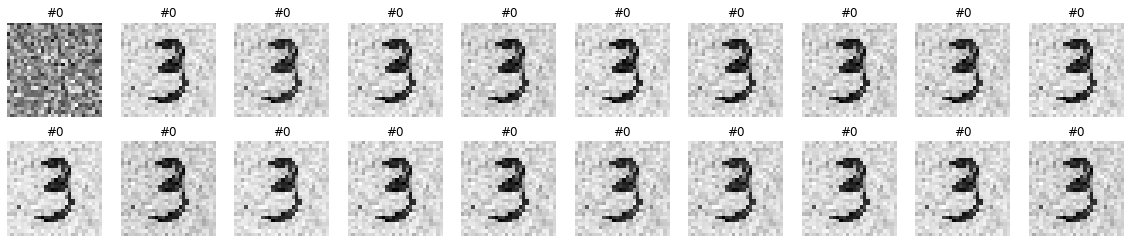

In [7]:
step = int(len(np.concatenate(outputs_G))/20)
subsetimages = np.concatenate(outputs_G)[0::step]
subsetpreds = np.concatenate(outputs_D)[0::step]

fig, ax = plt.subplots(nrows=int(len(subsetimages)/10), ncols=10, figsize=(20, 4), sharey=True, sharex=True)
for i, fig_x in enumerate(ax.flatten()):
  fig_x.axis('off')
  fig_x.imshow(subsetimages[i], cmap='gray_r')
  fig_x.set_title('#{}'.format(subsetpreds[i]))

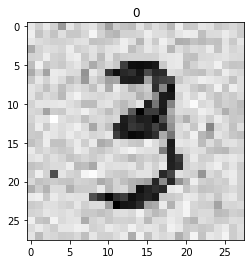

In [8]:
with torch.no_grad():
  generator.eval()
  x = Variable(torch.randn((1, 1, 28, 28)).to(device))
  y = generator(x)
  z = discriminator(y)
  p = torch.argmax(z)
  y = y.to('cpu')
  p = p.to('cpu')
  img = y[0].detach().numpy().squeeze()
  pred = p.detach().numpy().squeeze()
  plt.imshow(img, cmap='gray_r');
  plt.title(pred)

InfoGAN (MNIST with latent codes)
---
* https://arxiv.org/pdf/1606.03657.pdf

![](https://aiden.nibali.org/img/infogan_vs_gan_archs.svg)


In [0]:
class GeneratorInfo(nn.Module):
  def __init__(self):
    super(GeneratorInfo, self).__init__()

    self.layers = nn.Sequential(
        nn.ConvTranspose2d(74, 1024, 1, 1, bias=False),
        nn.BatchNorm2d(1024),
        nn.ReLU(),

        nn.ConvTranspose2d(1024, 128, 7, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.ConvTranspose2d(128, 64, 4, 2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.ConvTranspose2d(64, 1, 4, 2, padding=1, bias=False),
    )

  def forward(self, x):
    x = self.layers(x)
    y = torch.sigmoid(x)

    return y

class DiscriminatorInfo(nn.Module):
  def __init__(self):
    super(DiscriminatorInfo, self).__init__()

    self.layers = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.1),

        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.1),

        nn.Conv2d(128, 1024, kernel_size=7, bias=False),
        nn.BatchNorm2d(1024),
        nn.LeakyReLU(0.1),
    )

  def forward(self, x):
    x = self.layers(x)
    return x

class HeadD(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv = nn.Conv2d(1024, 1, 1)

  def forward(self, x):
    y = torch.sigmoid(self.conv(x))
    return y

class HeadQ(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.layers = nn.Sequential(
        nn.Conv2d(1024, 128, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.1, inplace=True)
    )
    
    self.conv_disc = nn.Conv2d(128, 10, 1)
    self.conv_mu = nn.Conv2d(128, 2, 1)
    self.conv_var = nn.Conv2d(128, 2, 1)

  def forward(self, x):
    x = self.layers(x)

    logits = self.conv_disc(x).squeeze()

    mu = self.conv_mu(x).squeeze()
    var = torch.exp(self.conv_var(x).squeeze())

    return logits, mu, var

class NormalNLLLoss:
  """
  Calculate the negative log likelihood
  of normal distribution.
  This needs to be minimised.
  Treating Q(cj | x) as a factored Gaussian.
  """
  def __call__(self, x, mu, var):
    logli = -0.5 * (var.mul(2 * np.pi) + 1e-6).log() - (x - mu).pow(2).div(var.mul(2.0) + 1e-6)
    nll = -(logli.sum(1).mean())

    return nll

def weights_init(m):
    """
    Initialise weights of the model.
    """
    if(type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif(type(m) == nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def noise_sample(n_dis_c, dis_c_dim, n_con_c, n_z, batch_size, device):
  """
  Sample random noise vector for training.
  INPUT
  --------
  n_dis_c : Number of discrete latent code.
  dis_c_dim : Dimension of discrete latent code.
  n_con_c : Number of continuous latent code.
  n_z : Dimension of iicompressible noise.
  batch_size : Batch Size
  device : GPU/CPU
  """

  z = torch.randn(batch_size, n_z, 1, 1, device=device)

  idx = np.zeros((n_dis_c, batch_size))
  if(n_dis_c != 0):
    dis_c = torch.zeros(batch_size, n_dis_c, dis_c_dim, device=device)
        
    for i in range(n_dis_c):
      idx[i] = np.random.randint(dis_c_dim, size=batch_size)
      dis_c[torch.arange(0, batch_size), i, idx[i]] = 1.0

      dis_c = dis_c.view(batch_size, -1, 1, 1)

  if(n_con_c != 0):
    # Random uniform between -1 and 1.
    con_c = torch.rand(batch_size, n_con_c, 1, 1, device=device) * 2 - 1

  noise = z
  if(n_dis_c != 0):
    noise = torch.cat((z, dis_c), dim=1)
  if(n_con_c != 0):
    noise = torch.cat((noise, con_c), dim=1)

  return noise, idx

In [43]:
# Initialise the network.
generator = GeneratorInfo().to(device)
generator.apply(weights_init)
print(generator)

discriminator = DiscriminatorInfo().to(device)
discriminator.apply(weights_init)
print(discriminator)

head_D = HeadD().to(device)
head_D.apply(weights_init)
print(head_D)

head_Q = HeadQ().to(device)
head_Q.apply(weights_init)
print(head_Q)

# Loss for discrimination between real and fake images.
criterion_D = nn.BCELoss()
# Loss for discrete latent code.
criterion_Q_dis = nn.CrossEntropyLoss()
# Loss for continuous latent code.
criterion_Q_con = NormalNLLLoss()

lr = 2e-4

# Adam optimiser is used.
optimizator_D = torch.optim.Adam([{'params': discriminator.parameters()}, {'params': head_D.parameters()}], lr=lr)
optimizator_G = torch.optim.Adam([{'params': generator.parameters()}, {'params': head_Q.parameters()}], lr=lr)

GeneratorInfo(
  (layers): Sequential(
    (0): ConvTranspose2d(74, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(1024, 128, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)
DiscriminatorInfo(
  (layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05,

In [51]:
#params['num_z'] = 62
#params['num_dis_c'] = 1
#params['dis_c_dim'] = 10
#params['num_con_c'] = 2

n_noize = 62
n_classes = 10
n_features = 2
n_epoches = 20

# Fixed Noise
z = torch.randn(100, n_noize, 1, 1)
fixed_noise = z

idx = np.arange(n_classes).repeat(10)
dis_c = torch.zeros(100, 1, n_classes)
for i in range(1):
  dis_c[torch.arange(0, 100), i, idx] = 1.0

dis_c = dis_c.view(100, -1, 1, 1)

fixed_noise = torch.cat((fixed_noise, dis_c), dim=1)

con_c = torch.rand(100, 2, 1, 1) * 2 - 1
fixed_noise = torch.cat((fixed_noise, con_c), dim=1)

real_label = 1
fake_label = 0

# List variables to store results pf training.
img_list = []
G_losses = []
D_losses = []

print("-"*25)
print("Starting Training Loop...\n")
print("-"*25)

start_time = time.time()
iters = 0

for epoch in range(n_epoches):
    epoch_start_time = time.time()

    for i, (data, _) in enumerate(ganloader, 0):
        # Get batch size
        b_size = data.size(0)
        # Transfer data tensor to GPU/CPU (device)
        real_data = data.to(device)

        # Updating discriminator and DHead
        optimizator_D.zero_grad()
        # Real data
        label = torch.full((b_size, ), real_label, device=device)
        output1 = discriminator(real_data)
        probs_real = head_D(output1).view(-1)
        loss_real = criterion_D(probs_real, label)
        # Calculate gradients.
        loss_real.backward()

        # Fake data
        label.fill_(fake_label)
        noise, idx = noise_sample(n_classes, 1, 2, n_noize, b_size, device)
        fake_data = generator(noise)
        output2 = discriminator(fake_data.detach())
        probs_fake = head_D(output2).view(-1)
        loss_fake = criterion_D(probs_fake, label)
        # Calculate gradients.
        loss_fake.backward()

        # Net Loss for the discriminator
        D_loss = loss_real + loss_fake
        # Update parameters
        optimizator_D.step()

        # Updating Generator and QHead
        optimizator_G.zero_grad()

        # Fake data treated as real.
        output = discriminator(fake_data)
        label.fill_(real_label)
        probs_fake = head_D(output).view(-1)
        gen_loss = criterion_D(probs_fake, label)

        q_logits, q_mu, q_var = head_Q(output)
        target = torch.LongTensor(idx).to(device)

        # Calculating loss for discrete latent code.
        dis_loss = 0
        for j in range(n_features):
          dis_loss += criterion_Q_dis(q_logits[:, j*10 : j*10 + 10], target[j])

        # Calculating loss for continuous latent code.
        con_loss = criterion_Q_con(noise[:, n_noize + 1*n_classes : ].view(-1, n_features), q_mu, q_var)*0.1

        # Net loss for generator.
        G_loss = gen_loss + dis_loss + con_loss
        # Calculate gradients.
        G_loss.backward()
        # Update parameters.
        optimizator_G.step()

        # Check progress of training.
        if i != 0 and i%100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch+1, n_epoches, i, len(dataloader), 
                    D_loss.item(), G_loss.item()))

        # Save the losses for plotting.
        G_losses.append(G_loss.item().detach())
        D_losses.append(D_loss.item().detach())

        iters += 1

    epoch_time = time.time() - epoch_start_time
    print("Time taken for Epoch %d: %.2fs" %(epoch + 1, epoch_time))
    # Generate image after each epoch to check performance of the generator. Used for creating animated gif later.
    with torch.no_grad():
        gen_data = generator(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True))

    # Generate image to check performance of generator.
    if((epoch+1) == 1 or (epoch+1) == n_epoches/2):
        with torch.no_grad():
            gen_data = generator(fixed_noise).detach().cpu()
        plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
        plt.savefig("Epoch_{}".format(epoch+1))
        plt.close('all')
'''
    # Save network weights.
    if (epoch+1) % params['save_epoch'] == 0:
        torch.save({
            'netG' : netG.state_dict(),
            'discriminator' : discriminator.state_dict(),
            'netD' : netD.state_dict(),
            'netQ' : netQ.state_dict(),
            'optimD' : optimD.state_dict(),
            'optimG' : optimG.state_dict(),
            'params' : params
            }, 'checkpoint/model_epoch_%d_{}'.format(params['dataset']) %(epoch+1))
'''

training_time = time.time() - start_time
print("-"*50)
print('Training finished!\nTotal Time for Training: %.2fm' %(training_time / 60))
print("-"*50)

# Generate image to check performance of trained generator.
with torch.no_grad():
    gen_data = generator(fixed_noise).detach().cpu()
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
plt.savefig("Epoch_{}".format(n_epoches))

'''
# Save network weights.
torch.save({
    'netG' : netG.state_dict(),
    'discriminator' : discriminator.state_dict(),
    'netD' : netD.state_dict(),
    'netQ' : netQ.state_dict(),
    'optimD' : optimD.state_dict(),
    'optimG' : optimG.state_dict(),
    'params' : params
    }, 'checkpoint/model_final_{}'.format(params['dataset']))
'''

# Plot the training losses.
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Loss Curve {}".format(params['dataset']))

# Animation showing the improvements of the generator.
fig = plt.figure(figsize=(10,10))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
anim.save('infoGAN_{}.gif'.format(params['dataset']), dpi=80, writer='imagemagick')
plt.show()

-------------------------
Starting Training Loop...

-------------------------


RuntimeError: ignored